In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.123558  0.253286  0.454621  0.568157  0.525143  1.205607  0.182703   
  1  -0.598526 -0.800568 -0.380944  0.481028 -0.087768  0.835702  1.115955   
  2  -0.082840 -0.809598  0.149484 -0.186686 -0.685578  0.450394  0.968310   
  3  -0.164309  0.142008  0.271763  0.250087  0.571928 -0.095893 -0.162390   
  4  -0.286434  0.614147 -0.270380  0.242590 -0.030565  0.230899 -0.129215   
  5  -0.238878  0.443017  0.587133 -0.668924  0.668586  0.841430 -0.232964   
  6  -1.069628 -0.326659  0.732153  0.002215 -0.395261  1.029679  0.091514   
  7  -0.880591  0.238764  0.444074  0.037222 -0.959053  0.289127 -0.058480   
  8  -0.252335  1.302863  0.381485 -0.800743 -0.515343  0.560533  0.678339   
  9  -0.715047  0.337445 -0.001977  0.062724 -0.146376 -0.329066  1.166065   
  10 -0.891362 -0.222733  1.191903  0.224308 -0.998402  0.105930 -0.481460   
  11 -1.015766 -0.420963  0.363733  0.680062  0.651945  0.269223  0.946923   
  12 -0.167308  0.844427 -0.364758 -0.065975 -0.725397  0.618983  0.306401   
  13 -0.391258  0.186218  0.713571  0.507425  0.114954  0.145108  0.654018   
  14  0.253102  0.299767  0.014442  0.569218 -0.415813  0.749024  0.211513   
  15 -0.364669  0.377438 -0.275801 -0.000737 -0.482054  0.941802 -0.621833   
  16 -0.152694  0.078412  0.911004 -0.134204 -0.927505  0.374895  0.456866   
  17 -0.414014 -0.030351  0.354463  0.860916 -0.028584  2.038671  1.179437   
  18 -0.346456 -0.996008  0.624966  0.075374 -1.022401  0.172732  0.025244   
  19 -0.286428  0.063567 -0.287875  0.005902 -0.293176  0.551541  0.943639   
  20  0.515527  0.304179  0.274490  0.299940  0.727463  1.124911  0.457738   
  21 -1.057394  0.402673  1.009526  0.825112 -0.504003  0.185819  0.284436   
  22  0.250597  0.450251 -0.682204  0.044653 -0.751133  0.701633 -0.042834   
  23 -1.056967 -0.537460 -0.791281  0.794113  0.390389  0.851769  0.860386   
  24  0.001469 -0.294567 -0.037707  0.515809 -0.713432  1.164801  0.331967   
1 0   0.330590  1.346968 -0.283290  1.136649  1.934926  0.305281  0.042038   
  1  -0.885176 -0.515774 -0.822630  0.788706  1.535903 -0.190374 -0.496516   
  2  -0.645871  0.979281  0.256215  0.190946  0.166388 -0.286755  0.378002   
  3  -0.641284  1.094833 -0.423045  0.981402  0.240271 -0.434363 -0.042397   
  4   0.079672  1.262094 -0.091187  0.290310 -0.398330  0.065615 -0.132013   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.760126  0.148034 -0.050919  ...  0.426693  0.215276 -0.614709   
  1   0.555765  0.315123 -0.700481  ... -0.257334  0.591870  1.150954   
  2  -0.580937  0.395218  0.962158  ...  0.237899  0.554829 -1.152677   
  3  -0.497622  0.258686 -0.111388  ...  0.464331 -0.130483 -0.052860   
  4  -0.169210  1.045921  0.207099  ...  0.347903  1.077865  0.410102   
  5  -1.051712  0.429811 -0.893015  ...  0.252303  0.333074  0.308630   
  6   0.575667 -0.543367  0.241837  ... -1.297758 -0.084019  0.139862   
  7  -0.424823  0.928862 -0.153676  ...  0.695847 -0.292614  0.006701   
  8   0.330535 -0.995628 -0.840375  ...  1.157447  0.551277  0.319482   
  9   0.837895  0.091818 -0.298435  ... -0.252538  0.592131  0.332994   
  10  0.294460  0.582782  0.771154  ... -0.274952  1.078369  0.979431   
  11  0.765266 -0.282774 -0.013349  ...  0.052299  0.292764 -0.272126   
  12 -1.037691  0.585679  0.473611  ... -0.045148  0.767656 -0.577087   
  13 -1.558655 -0.930542  0.117225  ...  0.935453  0.131402  0.252126   
  14 -0.125577 -0.414606  0.235488  ... -0.487164 -0.914233 -0.290006   
  15 -1.794021  0.260075  0.228179  ...  0.282414  0.711892 -0.531013   
  16 -0.960272  0.444774  0.438032  ... -0.340324  0.352293  0.128926   
  17 -0.280558  0.664852  1.402308  ...  0.549673  0.865555  0.277854   
  18 -0.303082 -0.224527 -0.498308  ...  0.142761  0.225803  0.375959   
  19  0.838943 -0.319050 -0.699593  ...  0.155234 -0.232240 -0.598415   
  20 -0.204562 -0.771511  0.382112  ... -0.222306  0.235890 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.114802  0.038465  28.981986  1.109885e-184  1.039411  1.190192


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



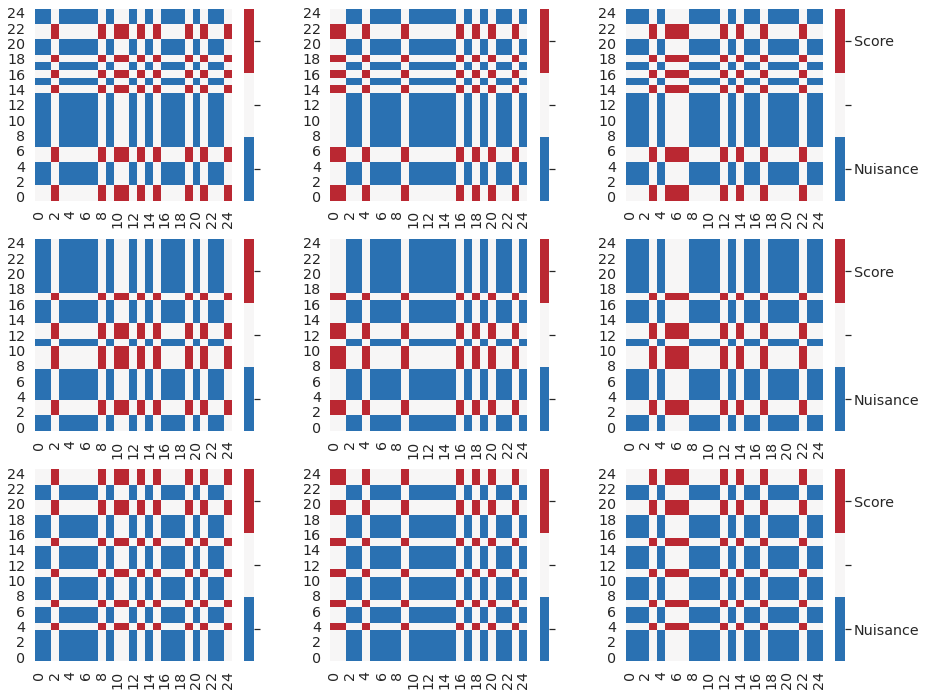

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



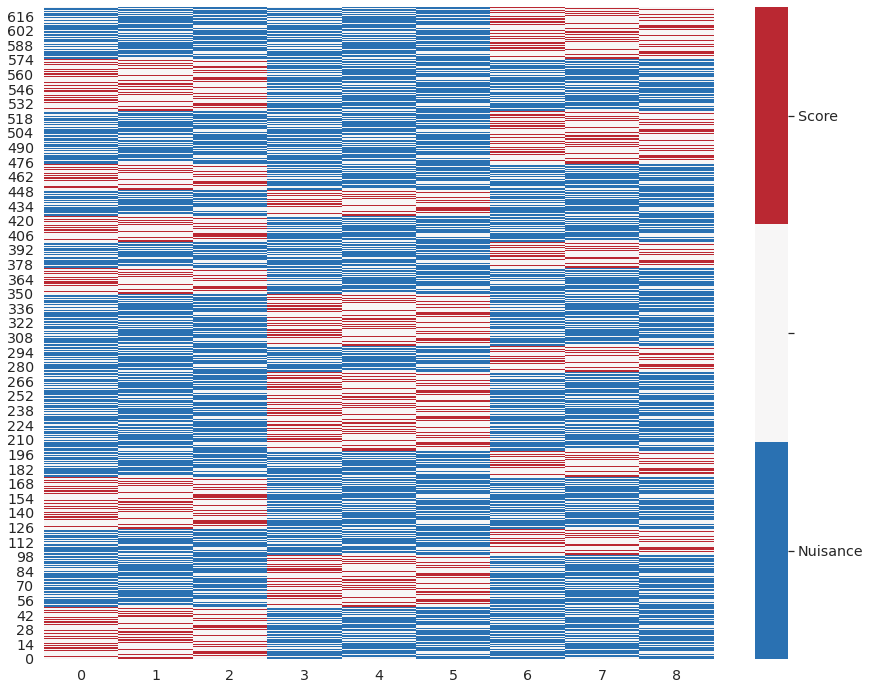

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])